<h1 align='center'> Monte-Carlo (MCMC) - TP6 (Homework due April 28 23h59) </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>


In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import quad

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$ 
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

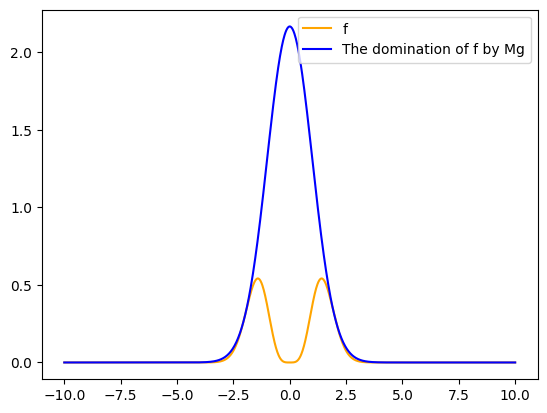

In [2]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)
M=max(f(x)/g(x))

plt.plot(x,f(x),color='orange',label="f")
plt.plot(x,M*g(x),color='blue',label="The domination of f by Mg")
plt.legend()
plt.show()

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [4]:
def rejection_sampling(n,M):
   X=[]

   for _ in range(n):
        y = np.random.normal(0, 1)  
        if np.random.uniform(0, 1) <= f(y) / (M * g(y)):  # Condition de rejet
            X.append(y)
   return  X
   


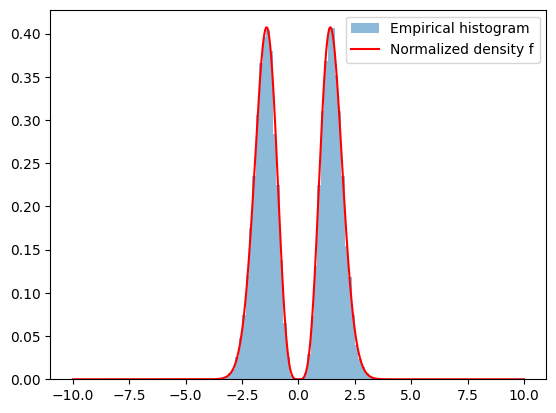

In [5]:
x = np.linspace(-10, 10, 1000)
n=100000
X_samples=rejection_sampling(n,M)
norma_const= quad(f, -np.inf, np.inf)[0]
f_norma= lambda x: f(x)/norma_const
plt.hist(X_samples, bins=50, density=True, alpha=0.5, label='Empirical histogram')
plt.plot(x, f_norma(x), color='red', label='Normalized density f')
plt.legend()
plt.show()

3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

In [6]:
def rw_metropolis_hastings(n, f=f, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """
    if seed is not None:
        np.random.seed(seed)
    X = [0]  # Initialisez X avec une valeur initiale non nulle
    for i in range(1, n):  # Commencez l'itération à partir de 1
        Y = X[-1] + np.random.normal() 
        rho = np.min([1, f(Y) / f(X[-1])])
        if np.random.uniform() < rho:
            X.append(Y)
        else:
            X.append(X[-1])
    return X



C:\Users\marye\AppData\Local\Temp\ipykernel_10112\3644012626.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  rho = np.min([1, f(Y) / f(X[-1])])


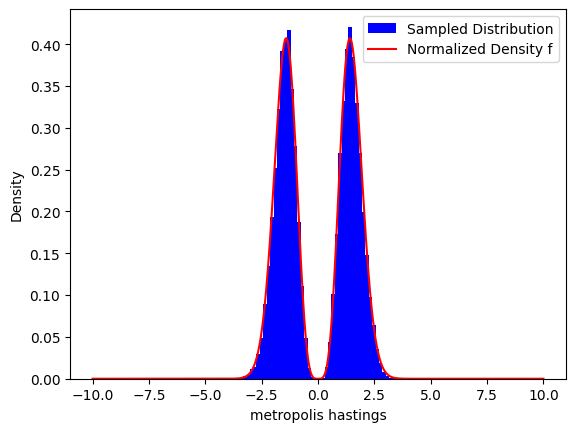

In [7]:
x = np.linspace(-10, 10, 1000)
X_samples = rw_metropolis_hastings(n, f)
plt.hist(X_samples, bins=50, density=True, color='blue', label='Sampled Distribution')
plt.plot(x, f_norma(x), color='red', label='Normalized Density f')
plt.xlabel('metropolis hastings')
plt.ylabel('Density')
plt.legend()
plt.show()

# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

$\color{orange}{\text{The parameters of the distribution are:}}$ : 


$$The\ mean\ \mu\  such\ that:   \mu = \begin{pmatrix} 0 \\ 0 \end{pmatrix} $$
$$The\ covariance\ matrix\  \Sigma\ is\ defined\ as: \Sigma = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$$
  
$\color{orange}{\text{For the Conditional distributions we have }}$ :

\begin{cases}
    p(x_1 | x_2) = \mathcal{N}(\rho x_2, 1 - \rho^2) \\
    p(x_2 | x_1) = \mathcal{N}(\rho x_1, 1 - \rho^2)
\end{cases}

*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [15]:
def gibbs_sampler(n,rho):
    """Gibbs sampler for (X_1, X_2)."""
    x = []
    x_1 = 0
    x_2 = 0
    for _ in range(n):
        x_1 = np.random.normal(rho * x_2 , 1 - rho**2)
        x_2 = np.random.normal(rho * x_1 , 1 - rho**2)
        x.append((x_1, x_2))
    X = np.array(x)
    return X

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

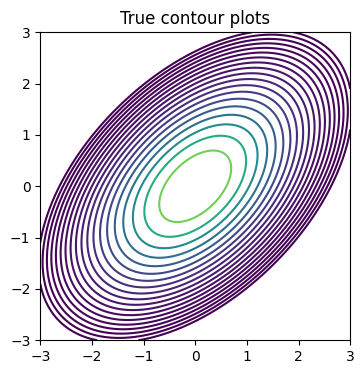

In [9]:
from scipy.stats import multivariate_normal
rho = 0.5
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

In [17]:
def plot_gibbs(n, R):
    
    fig, axes = plt.subplots(1, len(R), figsize=(20, 4))
    for idx, rho in enumerate(R):
        X = gibbs_sampler(n, rho)
        SIGMA = np.array([[1, rho], [rho, 1]])
        grid = np.linspace(-3, 3, 1000)
        x, y = np.meshgrid(grid, grid)
        pos = np.empty((1000, 1000, 2))
        pos[:, :, 0] = x
        pos[:, :, 1] = y
        true_density = multivariate_normal.pdf(pos, mean=[0, 0], cov=SIGMA)
        ax = axes[idx]
        ax.hist2d(X[:, 0], X[:, 1], bins=75, density=True)
        ax.contour(x, y, true_density, levels=np.logspace(-2, 0., 20) * true_density.max())
        ax.set_title(rf"$\rho = {rho}$")
    plt.tight_layout()
    plt.show()

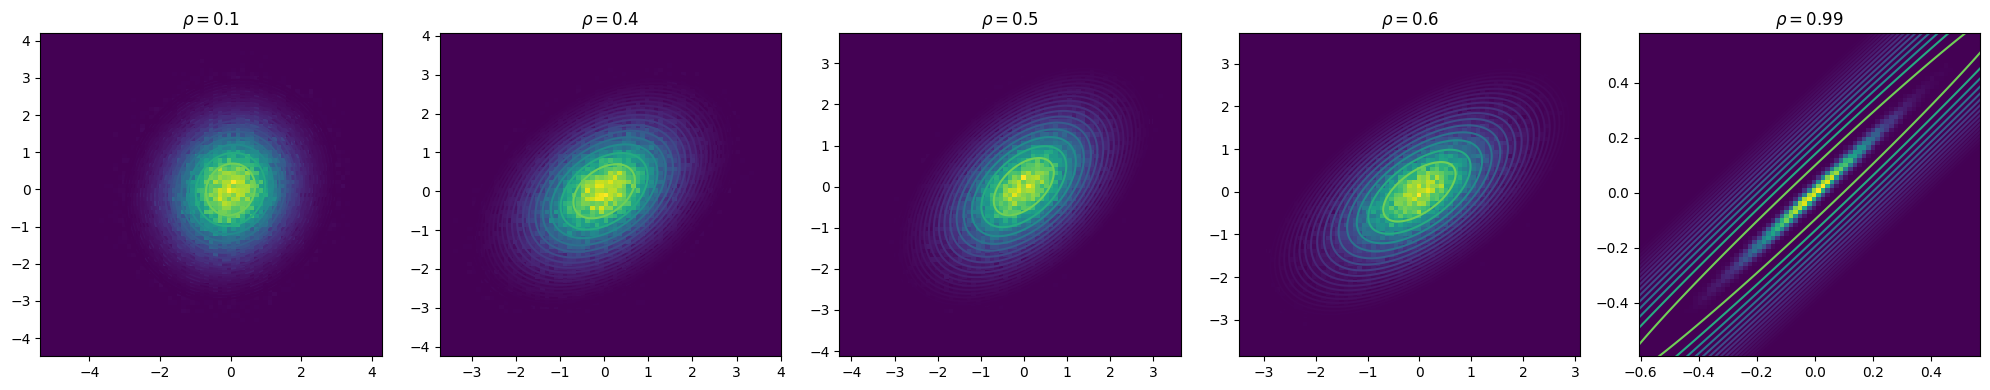

In [18]:
n = 100000
R = [0.1, 0.4, 0.5, 0.6, 0.99]
plot_gibbs(n, R)

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

In [19]:
def auto_correlation(X, M) :
    lag = np.arange(1, M+1)
    x_1 = []
    x_2 = []
    X_1 = X[:,0]
    X_2 = X[:,1]
    for l in lag:
        X1_lag = np.roll(X_1, l)[:-l]
        X2_lag = np.roll(X_2, l)[:-l]

        R1 = np.corrcoef(X_1[:-l], X1_lag)
        R2 = np.corrcoef(X_2[:-l], X2_lag)

        x_1.append(R1[0][1])
        x_2.append(R2[0][1])
        
    return [x_1, x_2]

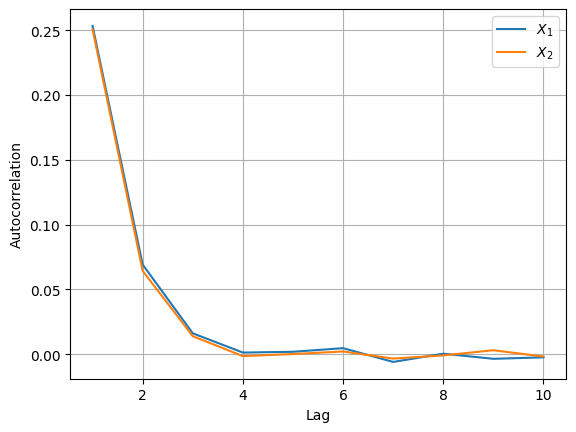

In [20]:
M = 10
rho = 0.5
n=100000
X = gibbs_sampler(n, rho)
plt.plot(np.arange(1, M+1), auto_correlation(X, M)[0], label=r"$X_1$")
plt.plot(np.arange(1, M+1), auto_correlation(X, M)[1], label=r"$X_2$")
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid()
plt.show()

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

When $\rho$ approaches 1 in the Gibbs sampler, it signifies that variables $X_1$ and $X_2$ are becoming highly correlated. Consequently, the sampler may encounter difficulty in efficiently exploring the sample space, as the variables tend to remain closely clustered.

To address this issue and enhance the simulation, two parameters could be introduced to the Gibbs sampler function:

    Lag Paramete: By adjusting the lag parameter, we can control how closely spaced our samples are in the output sequence.

    Thinning Interval:  By specifying a thinning interval, denoted as $n$, we can discard all but every $n$-th sample in the output sequence. This process effectively reduces the number of samples retained for analysis while preserving the independence of the retained samples.

Adjusting these parameters can improve the performance of the Gibbs sampler, facilitating better exploration of the sample space, particularly in scenarios where correlations between variables are nearing unity.

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$. 

In [21]:

def rw_metropolis_hastings(n, f, tau=1., seed=None):
    """Random walk Metropolis-Hastings algorithm for sampling from f with Gaussian proposal."""
    if seed is not None:
        np.random.seed(seed)
        
    # Initialization
    samples = np.zeros(n)
    current_value = np.random.rand()
        
    # Here we perform the Metropolis-Hastings iterations
    for i in range(n):
        proposed_value = current_value + np.random.normal(scale=np.sqrt(tau))
        acceptance_ratio = f(proposed_value) / f(current_value)
        # Here we accept or reject
        if np.random.rand() < acceptance_ratio:
            current_value = proposed_value
        
        samples[i] = current_value

    return samples
